![mslogo](images/microsoft_logo.jpg)

# Microsoft Film Studios Recommendations

**Author:** Brian Tracy
***

## Overview
***

Newly created Microsoft Film Studios is looking for recommendations on what their first film should be. Analysis of film metadata from IMDB and financial data from The Numbers will be used to make recommendations to the studio.

## Business Problem
***

Microsoft, one of the big five tech companies in the world, is the last to make the foray into original video content production. While the company may know almost everything about making software people will use, they don't know much about making films people will watch. What they lack in knowledge they make up for in resources, and now they want to throw their weight against the box office and make a successful movie.


Questions being considered:

- What genre of films has been most financially successful?
- When should the film be released?
- How much should the budget be?
- Are there any directors that stand out in that genre?
- Are any particular actors within that genre more successful?

## Data Understanding
***

IMDB, the Internet Movie Database, is one of the largest sites for movie news and information. They provide data such as ratings, film titles, genres, crew and principals, and biographical data. The data files provided for the project are from 2019.

The Numbers is a website for movie financial information. They provide data on production costs and gross sales. The data files provided for the project are also from 2019.

# Set up DataFrames

## Loading datasets

Perform standard imports of pandas, numpy, seaborn, and matplotlib, along with the magic line to print plots in our jupyter notebook.

The 3 main datasets for analysis are:
- title.basics.csv
- title.ratings.csv
- tn.movie_budgets.csv

The first two datasets contain movie name and rating information and will be merged on unique identifier 'tconst', as well as unique IDs to get cast and crew names from the additional datasets. The tn.movie_budgets dataset does not share this identifier, but it has the financial data and release information needed for analysis.

The 3 additional datasets to explore:
- name.basics.csv
- title.crew.csv
- title.principals.csv

The crew and principals datasets contain lists of people who work on or in films, and each entry contains the 'tconst' unique identifiers to link the movie data. They also contain another shared identifier connecting the name.basics dataset for biographical information like names, birth/death dates, and roles.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# load the main title datasets
title_basics = pd.read_csv('Data/title.basics.csv')
title_ratings = pd.read_csv('Data/title.ratings.csv')

# make a new dataframe joining the basic info with ratings
movie_ratings = pd.merge(title_basics, title_ratings, on='tconst')

# load the movie budget dataset
movie_budget = pd.read_csv('Data/tn.movie_budgets.csv')

# load the additional datasets for cast/crew
name_info = pd.read_csv('data/name.basics.csv')
crew = pd.read_csv('data/title.crew.csv')
principals = pd.read_csv('data/title.principals.csv')

In [2]:
# This cell will turn off the pink warning messages for final submission if we still have any
import warnings
warnings.filterwarnings('ignore')

## Checking null values

In [3]:
print('Total movie_ratings prior to cleaning:', len(movie_ratings))
print('movie_ratings null values:')
for col in movie_ratings.columns:
    print('- ', col, '-', movie_ratings[col].isna().sum())
print('\n')

print('Total movie_budget prior to cleaning:', len(movie_budget))
print('movie_budget null values:')
for col in movie_budget.columns:
    print('- ', col, '-', movie_budget[col].isna().sum())

Total movie_ratings prior to cleaning: 73856
movie_ratings null values:
-  tconst - 0
-  primary_title - 0
-  original_title - 0
-  start_year - 0
-  runtime_minutes - 7620
-  genres - 804
-  averagerating - 0
-  numvotes - 0


Total movie_budget prior to cleaning: 5782
movie_budget null values:
-  id - 0
-  release_date - 0
-  movie - 0
-  production_budget - 0
-  domestic_gross - 0
-  worldwide_gross - 0


***
Null value decisions:
- Of the 73,856 records, only 804 do not have a genre (approximately 1%). Rows not containing a genre will be dropped
- There are no plans to use runtime_minutes as part of the film analysis, so the column will be dropped

In [4]:
movie_ratings.drop('runtime_minutes', axis=1, inplace=True)
movie_ratings.dropna(inplace=True)

## Correcting datatypes

In movie_ratings the genres are strings that are multiple genres, we need to make them into lists of genres for analysis. 

In [5]:
movie_ratings['genres'] = movie_ratings['genres'].map(lambda x: x.split(','))

In movie_budget, the budget and two gross columns are strings with '$' and ',' in them, we need to change them to int for analysis.

In [6]:
movie_budget['production_budget'] = movie_budget['production_budget'].map(
    lambda x: x.replace('$','').replace(',', '')).astype(np.int64)
movie_budget['domestic_gross'] = movie_budget['domestic_gross'].map(
    lambda x: x.replace('$','').replace(',', '')).astype(np.int64)
movie_budget['worldwide_gross'] = movie_budget['worldwide_gross'].map(
    lambda x: x.replace('$','').replace(',', '')).astype(np.int64)

##  EDA

Exploring the date ranges of our data

In [7]:
# convert release_date column to datetime dtype, make new column for year
movie_budget['release_date'] = pd.to_datetime(movie_budget['release_date'])
movie_budget['year'] = movie_budget['release_date'].map(lambda x: x.year)

print('movie_ratings year range:\n', list(movie_ratings['start_year'].
       value_counts().index.sort_values()), '\n')

print('movie_budget year range:\n', list(movie_budget['year'].value_counts(
    ).index.sort_values()))

movie_ratings year range:
 [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 

movie_budget year range:
 [1915, 1916, 1920, 1925, 1927, 1929, 1930, 1931, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


> movie_ratings doesn't have any data prior to 2010. The business problem is framed as exploring films 'currently doing the best at the box office'; removed entries of movie_budget prior to 2010

In [8]:
movie_budget = movie_budget[movie_budget['year'] >= 2010]
movie_budget.reset_index(inplace=True)
movie_budget.drop(['index', 'id'], axis=1, inplace=True)

***
Exploring the financial gross figures

In [9]:
zero_dom_gross = len(movie_budget[movie_budget.domestic_gross == 0])
zero_tot_gross = len(movie_budget[(movie_budget.domestic_gross == 0) & (
                                   movie_budget.worldwide_gross == 0)])
inter_only = zero_dom_gross - zero_tot_gross

print(f"Total films with no domestic gross: {zero_dom_gross}")
print(f"Total films with no total gross: {zero_tot_gross}")
print(f"Total films only international gross: {inter_only}")

Total films with no domestic gross: 407
Total films with no total gross: 272
Total films only international gross: 135


> Decided to drop all films with no domestic gross. It is likely that films with only international gross are made by foreign film studios for different markets. Analysis should be of domestic films.

In [10]:
movie_budget.drop(movie_budget.loc[movie_budget['domestic_gross'] == 0].index,
                  inplace=True)
movie_budget.reset_index(inplace=True, drop=True)

## Merging title and financial data

Tested two merges:
- inner merge on original_title / movie
- inner merge on primary_title / movie

Out of the 1787 entries in movie_budget, merging on original_title produces 1774 entries while primary_title produces 1835, so we will go with that. This is likely due to one-to-many matches, we will check for duplicates.

Explored using fuzzywuzzy to match title fields that were formatted slightly differently (i.e. using parentheses or colons in the title in one df but not the other). Elected to just go with the inner join on primary_title and cut our losses for now but this would be an area for improving the analysis by matching more films by title. How much of the 6% data loss would be recovered would be another question, and how that would affect the results as well.

In [11]:
df = pd.merge(movie_ratings, movie_budget, how='inner',
              left_on='primary_title', right_on='movie')

The following columns will be dropped:
- primary_title, original_title. We will use the movie column
- start_year. We will use release_date

Duplicates also dropped.

In [12]:
df.drop(['primary_title', 'original_title', 'start_year'], axis=1,
        inplace=True)

df.drop_duplicates(subset=['movie', 'release_date'], keep='first',
                   inplace=True)

# temp set index to movie, then reset so that indicies are correct and movie
# is the first column in our resulting df
df.set_index('movie', inplace=True)
df.reset_index(inplace=True)

## Engineering additional features

Gross sales is certainly an important metric, but profit and return on investment may also prove interesting. We will create two new columns with these categories.

In [13]:
df['profit'] = df['worldwide_gross'] - df['production_budget']
df['roi'] = df['profit'] / df['production_budget']
display(df.info())
# format the descibe() so it's easier to read financials
df[['production_budget', 'domestic_gross', 'worldwide_gross', 'profit',
   ]].describe().apply(lambda x: x.apply('${0:,.2f}'.format))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie              1507 non-null   object        
 1   tconst             1507 non-null   object        
 2   genres             1507 non-null   object        
 3   averagerating      1507 non-null   float64       
 4   numvotes           1507 non-null   int64         
 5   release_date       1507 non-null   datetime64[ns]
 6   production_budget  1507 non-null   int64         
 7   domestic_gross     1507 non-null   int64         
 8   worldwide_gross    1507 non-null   int64         
 9   year               1507 non-null   int64         
 10  profit             1507 non-null   int64         
 11  roi                1507 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 141.4+ KB


None

,production_budget,domestic_gross,worldwide_gross,profit
count,"$1,507.00","$1,507.00","$1,507.00","$1,507.00"
mean,"$44,821,841.17","$56,818,703.70","$142,416,221.39","$97,594,380.21"
std,"$55,708,476.24","$84,209,875.52","$232,151,954.70","$191,689,314.56"
min,"$9,000.00",$388.00,$528.00,"$-200,237,650.00"
25%,"$8,950,000.00","$4,756,283.00","$11,303,079.50","$-191,988.50"
50%,"$24,200,000.00","$28,370,522.00","$54,393,687.00","$25,358,392.00"
75%,"$55,000,000.00","$67,767,723.50","$160,069,202.00","$107,627,902.00"
max,"$410,600,000.00","$700,059,566.00","$2,048,134,200.00","$1,748,134,200.00"


The dataframe "df" contains 1507 entries for films from 2010 to 2019. This will be the default dataframe that we expand on for the questions we are trying to answer.
***

This cell sets our formatting for millions or billions of dollars in subsequent visualizations, ex. \\$12M or \\$163B

In [14]:
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

# functions to change formatting to be easier to read

def millions(x,pos):
    return f"${x*1e-6:,.0f}M"

def billions(x,pos):
    return f"${x*1e-9:,.0f}B"

mill_fmt = FuncFormatter(millions)
bill_fmt = FuncFormatter(billions)

# Business Problems

## Question 1: What genre of film to produce?

We can explode out our dataframe based on the genre column so that movies with multiple genres can be counted in each type comparison.

Exploding "genres" increases our number of entries from 1507 to 3808

In [15]:
df_genres = df.explode('genres')

First get a representation of the frequency of each genre

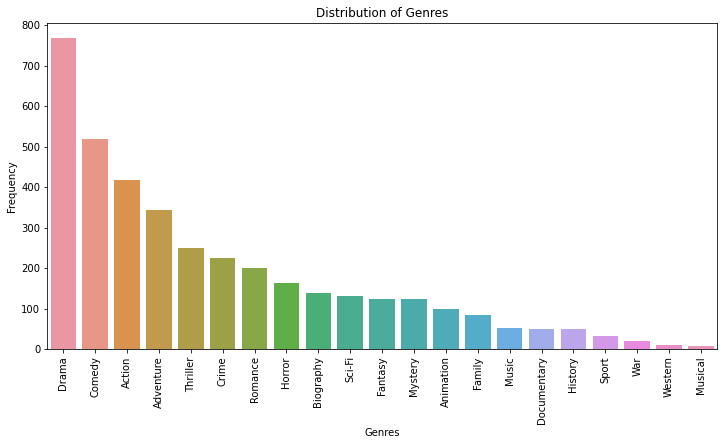

In [16]:
# copy df_genres, get count and sort descending
df_genres_copy = df_genres.groupby('genres').count().sort_values('tconst',
                                                            ascending=False)
df_genres_copy.reset_index(inplace=True)

# set up barplot to represent frequency of genres
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.barplot(data=df_genres_copy, x='genres', y='tconst')
ax.set(title='Distribution of Genres', xlabel='Genres', ylabel='Frequency')
plt.setp(ax.get_xticklabels(), rotation=90); # better orientation of ticks

> We have 21 genres, 9 of which are represented by less than 100 films. We will leave them in for now and see what initial analysis looks like.
***

There are three numerical columns that we will plot for initial analysis of genre:
- Domestic Gross
- Worldwide Gross
- Profit

Initial visualizations showed a marked disparity between the top 5 genres and the remainder in all three financial categories. For the non-technical presentation we will use the top five genres in each category

In [17]:
# get the order for top genres in each financial category, limit to top 5
dom_order = df_genres.groupby('genres')['domestic_gross'].mean().sort_values(
    ascending=False).index[0:5]
wor_order = df_genres.groupby('genres')['worldwide_gross'].mean().sort_values(
    ascending=False).index[0:5]
prof_order = df_genres.groupby('genres')['profit'].mean().sort_values(
    ascending=False).index[0:5]

# dictionary of genre colors
color_dict = {'Animation': 'blue', 'Adventure': 'orange', 'Sci-Fi': 'green',
             'Action': 'red', 'Fantasy': 'purple'}

dom_order_list = [color_dict[x] for x in dom_order]
wor_order_list = [color_dict[x] for x in wor_order]
prof_order_list = [color_dict[x] for x in prof_order]

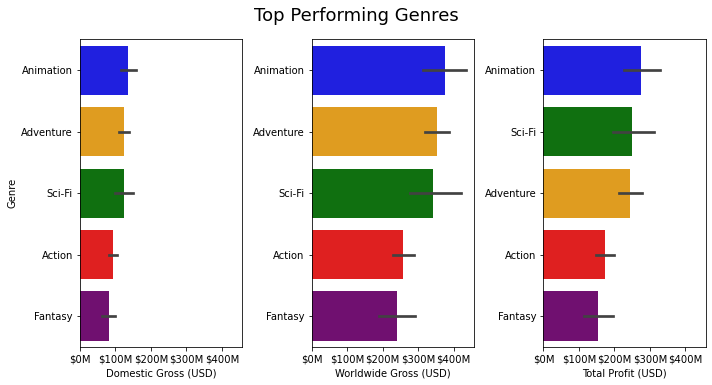

In [18]:
# set up 3 column figure for plotting barplots of each financial category
# have them share the x-axis to keep financials in perspective
fig, axes = plt.subplots(ncols=3, figsize=(10,5), sharex=True)

# left column - domestic gross 
sns.barplot(ax=axes[0], data=df_genres, x='domestic_gross', y='genres',
            order=dom_order, palette=dom_order_list)
axes[0].set(xlabel='Domestic Gross (USD)', ylabel='Genre')
axes[0].xaxis.set_major_formatter(bill_fmt)

# middle column - worldwide gross
sns.barplot(ax=axes[1], data=df_genres, x='worldwide_gross', y='genres',
            order=wor_order, palette=wor_order_list)
axes[1].set(xlabel='Worldwide Gross (USD)', ylabel=None)
axes[1].xaxis.set_major_formatter(bill_fmt)

# right column - profit
sns.barplot(ax=axes[2], data=df_genres, x='profit', y='genres',
            order=prof_order, palette=prof_order_list)
axes[2].set(xlabel='Total Profit (USD)', ylabel=None)
axes[2].xaxis.set_major_formatter(mill_fmt)

plt.tight_layout()

# set suptitle to include in saved image
genre_suptitle = fig.suptitle('Top Performing Genres', y=1.06, fontsize=18);

# save figure
fig.savefig('images/top_genres.png', facecolor='white', bbox_inches='tight',
            bbox_extra_artists=[genre_suptitle])

> Animation tops the average of all three financial categories: domestic, worldwide, and profit.

***

Animated films almost always have additional genre categories.

In [19]:
df_animation = df_genres[df_genres['genres'] == 'Animation']
df_animation.reset_index(inplace=True, drop=True)

# value_counts is on genres_x due to duplicate names on merge
pd.merge(df_genres, df_animation, how='inner',
         on='tconst').value_counts('genres_x')

genres_x
Animation    99
Adventure    86
Comedy       75
Action       21
Family        9
Drama         2
Fantasy       1
dtype: int64

Merging df_genres with df_animation generates a one-to-many relationship that can be used to show the value counts of the other genres that often accompany animated films.

> If animation films perform best in worldwide gross, the major co-genres with animation would be Adventure and Comedy. The data would endorse making an animated **adventure/comedy.**
***

## Question 2: When should the film release?

Does the data support releasing the movie in a particular month? To explore we will plot average profit per month with columns for animated and non-animated films and see how they compare.

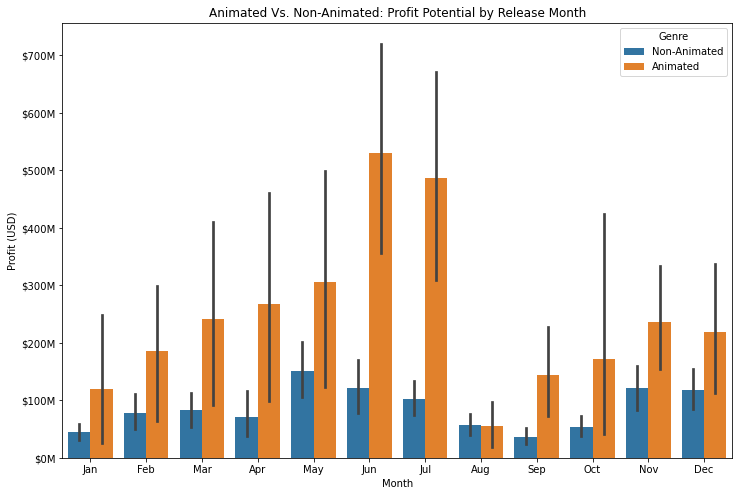

In [20]:
# create copies of original df and df_animation
df_copy = df.copy()
df_animation_copy = df_animation.copy()

# change genres from lists to strings
df_copy['genres'] = df_copy['genres'].astype(str)

# engineer a  feature is_animation, to indicate if the film is animated
df_copy['is_animation'] = df_copy['genres'].str.contains('Animation')
df_copy['is_animation'] = df_copy['is_animation'].replace({True:'Animated',
                                                        False:'Non-Animated'})

# engineer a feature in each copy called "month" from release_date
df_copy['month'] = df_copy['release_date'].map(lambda x: x.strftime("%b"))
df_animation_copy['month'] = df_animation_copy['release_date'].map(
    lambda x: x.strftime("%b"))

# list of the correct order of months
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
          "Oct", "Nov", "Dec"]

# set up figure
fig, ax = plt.subplots(figsize=(12,8))

# set up barplot. renamed is_animation to Genre for aesthetics. 
# profit by month with hue as 'Genre' (really is_animation)
ax = sns.barplot(data=df_copy.rename({'is_animation': 'Genre'}, axis=1), 
                 x='month', y='profit', hue='Genre', order=months)

# set y-axis format for millions
ax.yaxis.set_major_formatter(mill_fmt)
ax.set(title='Animated Vs. Non-Animated: Profit Potential by Release Month',
       xlabel='Month', ylabel='Profit (USD)');

fig.savefig('images/release_month.png', facecolor='white')

> The financial data for profit would endorse a June release for an animated film. It is notable that the data has large variance tails on them, so it's not a guarantee, but there is certainly a huge disparity between all other genres and Animation in the summer months of June and July.

## Question 3: How much should the budget be?

Visualize two scatterplots with linear regression line, one for domestic_gross and one for worldwide_gross, both compared to production_budget

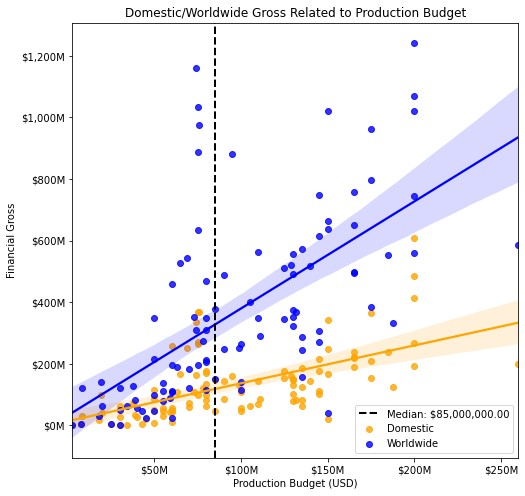

In [21]:
# set up figure. share y so we can illustrate scale of gross
fig, ax = plt.subplots(figsize=(8,8), sharey=True)

# orange dots/line will be domestic_gross as a function of production_budget
ax1 = sns.regplot(data=df_animation, x='production_budget',
                 y='domestic_gross', color='orange', label='Domestic')

# blue dots/line will be domestic_gross as a function of production_budget
ax2 = sns.regplot(data=df_animation, x='production_budget',
                 y='worldwide_gross', color='blue', label='Worldwide')

# include a line for the median
median = df_animation["production_budget"].median()
ax.axvline(median, label=f'Median: ${median:,.2f}', color='black', ls='--',
           lw='2')

# include a legend
ax.legend()

# set title and axis labels
ax.set(title='Domestic/Worldwide Gross Related to Production Budget',
      xlabel='Production Budget (USD)',
      ylabel = 'Financial Gross')

# format the financial representations nicely
ax.yaxis.set_major_formatter(mill_fmt)
ax.xaxis.set_major_formatter(mill_fmt);

# save figure
fig.savefig('images/budget_gross.png', facecolor='white')

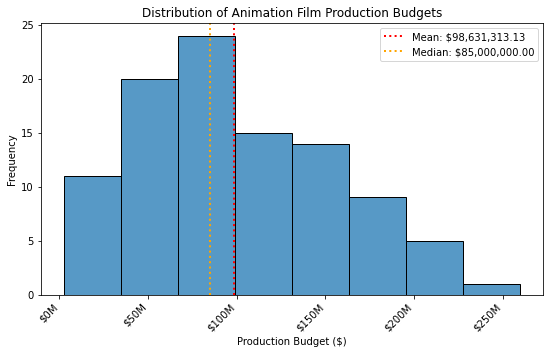

In [22]:
# set up figure
fig, ax = plt.subplots(figsize=(9,5))

# histogram using df_animation on production_budget
sns.histplot(data=df_animation, x='production_budget', ax=ax)

ax.set(title='Distribution of Animation Film Production Budgets',
      xlabel='Production Budget ($)', ylabel='Frequency')

# include a line for the mean
mean = df_animation['production_budget'].mean()
ax.axvline(mean, label=f'Mean: ${mean:,.2f}', color='red', ls=':', lw='2')

# include a line for the median
median = df_animation["production_budget"].median()
ax.axvline(median, label=f'Median: ${median:,.2f}', color='orange', ls=':',
           lw='2')

# include a legend for the mean/median
ax.legend()

# rotate x tick-labels slightly to better read
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

# format the financial representations nicely
ax.xaxis.set_major_formatter(mill_fmt);

> The average production budget for animated films is just under \\$100 million. There is a clear positive relationship between production budget and both financial gross features; it is more pronounced in worldwide gross. However, there are many films made for less than average that grossed as much or more than films made with double the budget. The data supports the recommendation that Microsoft spend between \\$100-\\$200 million producing a film they should market and release to an international audience.

## Additional exploration: who should direct? Who should star?

Can the data say anything about directors?

In [23]:
# merge df_animation with crew on unique ID tconst
df_animation_crew_raw = pd.merge(left=df_animation, right=crew, on='tconst')

# create lists of directors if multiple
df_animation_crew_raw['directors'] = df_animation_crew_raw['directors'].map(
    lambda x: x.split(','))

# explode the dataframe on directors
df_animation_crew = df_animation_crew_raw.explode('directors')

# merge animation_crew with name_info to get more bio data
df_directors = pd.merge(df_animation_crew, name_info, how='inner',
                        left_on='directors', right_on='nconst')

# get the array of number of films each director has directed in animation
films_directed = df_directors['directors'].value_counts().values

# https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-
# counts-for-unique-values-in-an-array
unique, counts = np.unique(films_directed, return_counts=True)

# shows how many directors directed that many animated films
print(np.asarray((unique, counts)).T)

[[ 1 95]
 [ 2 14]
 [ 3  5]
 [ 4  3]]


Most animated film directors have only directed one movie, while some have directed several. No one director has done more than 4 animated films.

We will likely not have enough aggregate data on each director to make significant recommendations.

Out of curiosity we will report the top worldwide grossing directors in animation, or all directors whose average worldwide_gross is over 1 billion USD.

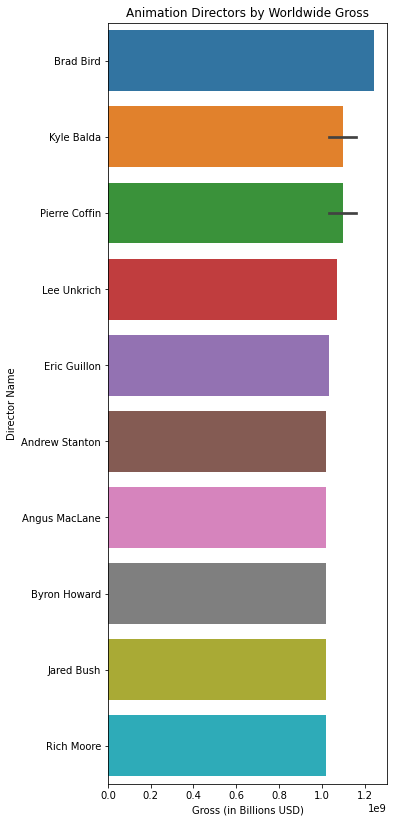

In [24]:
df_top_directors = df_directors[df_directors['worldwide_gross'] >= 1000000000]
df_top_directors.sort_values('worldwide_gross', ascending=False)
df_top_directors.set_index('primary_name', inplace=True, drop=True)
df_top_directors.reset_index(inplace=True)

# set the order for directors to be displayed in
top_directors = df_top_directors.groupby('primary_name').mean().sort_values(
    'worldwide_gross', ascending=False).index

# set up figure
plt.figure(figsize=(5,14))

# barplot of top_directors by worldwide_gross
sns.barplot(data=df_top_directors, x='worldwide_gross', y='primary_name',
            order=top_directors)
plt.title('Animation Directors by Worldwide Gross')
plt.xlabel('Gross (in Billions USD)')
plt.ylabel('Director Name');

> There is not enough data to make any statistically significant recommendation for director.

***

Can the data say anything about actors?

In [25]:
# merge df_animation with principals to get animated principals
df_actors_raw = pd.merge(left=df_animation, right=principals, how='inner',
                         on='tconst')

# limit to just actor and actress categories
df_actors_raw = df_actors_raw[df_actors_raw['category'].isin(
    ['actor', 'actress'])]

# merge the animated actors with name_info for bio data
df_actors_names_raw = pd.merge(df_actors_raw, name_info, how='inner',
                               on='nconst')
df_actors_names_raw.set_index('primary_name', inplace=True)
df_actors_names_raw.reset_index(inplace=True)

# make sure there are not any deceased actors that we may actually recommend
df_actors_alive = df_actors_names_raw[
    ~df_actors_names_raw['death_year'].notnull()]

# set df_actors by cleaning up by dropping unneeded columns
df_actors = df_actors_alive.drop(['genres','averagerating','numvotes',
                                  'ordering','nconst','category','job',
                                  'characters','birth_year','death_year',
                                  'primary_profession', 'known_for_titles'],
                                   axis=1)

# create df from df_actors to get count of films they have been in
df_actors_grouped = df_actors.groupby('primary_name').count().sort_values(
    'tconst', ascending=False)

# create a new df for those actors in animation in more than 1 movie
df_actors_mult_films = df_actors_grouped[df_actors_grouped['tconst'] > 1]

# remove unnecessary data
df_actors_film_count = df_actors_mult_films.iloc[: , :-8]

# group df_actors by their primary_name and gets their mean aggregate
df_actors_grouped = df_actors.groupby('primary_name').mean()
df_actors_grouped.reset_index(inplace=True)

# merge the grouped actors with film count
df_actors_gross = pd.merge(df_actors_grouped, df_actors_film_count,
                           how='inner', on='primary_name')

# show the value counts for multi-film animation actors
print('Actor counts for number of films')
print(df_actors_gross['movie'].value_counts())
print("\n Normalized to show percent")
print(df_actors_gross['movie'].value_counts(normalize=True))

Actor counts for number of films
2    44
3    15
4     3
Name: movie, dtype: int64

 Normalized to show percent
2    0.709677
3    0.241935
4    0.048387
Name: movie, dtype: float64


70% of our mutli-film actors have only been in 2 films. Only 18 actors have been in 3 or 4 films. Given the nature of animated films, and from looking at the data, it's likely most of the multi-film actors are from the same franchise (Despicable Me, Kung Fu Panda, Hotel Transylvania, etc.)

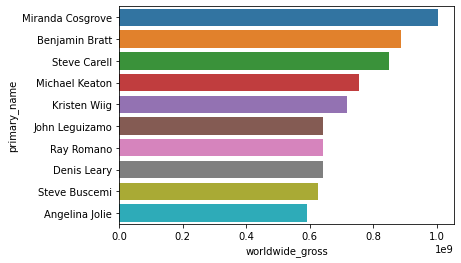

In [26]:
sns.barplot(x='worldwide_gross', y='primary_name', 
            data=df_actors_gross.sort_values('worldwide_gross',
                                             ascending=False)[0:10]);

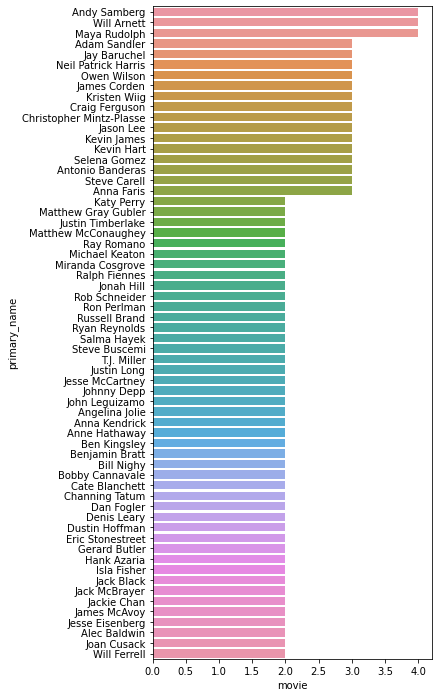

In [27]:
plt.figure(figsize=(5, 12))

sns.barplot(x='movie', y='primary_name', 
            data=df_actors_gross.sort_values('movie',
                                             ascending=False));

> The data does not clearly support any particular actor in any meaningful statistical measure.

***

# Conclusions

The data supports making the following recommendation to Microsoft Film Studios:
- Produce an **animated** feature film that is
- An **adventure/comedy**
- Released in **June**
- To a **worldwide audience**
- With a budget of at between **\\$100M-\\$200M (USD)**


***
The recommendations for genre, release month, and budget are all solidly supported by descriptive statistics of our film data. Animated films perform best, and the most common co-genres are adventure/comedy. Animated films have the highest profit potential in June compared to non-animated films. A higher budget results in higher gross, especially when released internationally.
***

# Next Steps

In section 2.5 we highlighted that merging our data did not result in all films from our financial dataset being merged with the meta-data. Further exploration showed that there were inconsistencies in naming of films between the two datasets that resulted in data loss during the merge. **Better sourced data would be one recommended next step.**

The scope of the data we collect is important. IMDB data was from 2010 and later, but financial data went back decades. It would be recommended to expand initial analysis to a larger dataset including more years, making sure to adjust for inflation to see how genres performed over time. It would be interesting to look at the market share of genres over time to see if any patterns emerge.

Additionally, data on original IPs vs franchises would be interesting to look at, as well as production studios. Looking at our top grossing films we see most are from Disney/Pixar and Dreamworks. These companies have enormous resources and reputation behind them that will make it difficult to compete.

It is more than just the director and the star that make a successful movie. There are writers, producers, other crew members and supporting actors. There is also the time of year a movie is released, other films it's competing with, marketing, etc. We suspect that no matter the amount of data collected for all of these additional features there would still not be a clear recommendation for a guaranteed financial success.

A last recommendation for next step would be to analyze public interest in newer properties that have not yet been optioned. Look at books and television for hot trends that could be ported to a successful animated action/adventure film.